# Evaluation of Explanations

In [21]:
%cd C:\Users\miche\Documents\PatchTST\PatchTST_supervised\

C:\Users\miche\Documents\PatchTST\PatchTST_supervised


C:\Users\miche\anaconda3\envs\patchtst\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
class Args:
    # random seed
    random_seed = 2021

    # basic config
    is_training = 1
    model_id = 'test'
    model = 'PatchTST_Attention'

    # data loader
    data = 'weather'
    root_path = './dataset'
    data_path = 'weather_int.csv'
    features = 'MS'
    target = 'T (degC)'
    freq = '10T'
    checkpoints = './checkpoints/'

    # forecasting task
    seq_len = 336
    label_len = 10
    pred_len = 10

    # PatchTST
    fc_dropout = 0.2
    head_dropout = 0.0
    patch_len = 16
    stride = 8
    padding_patch = 'end'
    revin = 1
    affine = 0
    subtract_last = 0
    decomposition = 0
    kernel_size = 25
    individual = 1  # True

    # Formers
    embed_type = 0
    enc_in = 7
    dec_in = 7
    c_out = 1
    d_model = 70
    n_heads = 7
    e_layers = 3
    d_layers = 1
    d_ff = 280
    moving_avg = 25
    factor = 1
    distil = True
    dropout = 0.2
    embed = 'timeF'
    activation = 'gelu'
    output_attention = True
    do_predict = False

    # optimization
    num_workers = 4
    itr = 1
    train_epochs = 100
    batch_size = 128
    patience = 5
    learning_rate = 0.0001
    des = 'Exp'
    loss = 'mse'
    lradj = 'type3'
    pct_start = 0.3
    use_amp = False

    # GPU
    use_gpu = True
    gpu = 0
    use_multi_gpu = False
    devices = '0,1,2,3'
    test_flop = False


args = Args()



In [11]:
import torch
from models.PatchTST_Attention import Model  # wherever you define PatchTST
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_patch = torch.load(
    r"C:\Users\miche\Documents\PatchTST\PatchTST_supervised\scripts\PatchTST\checkpoints"
    r"\weather_int_336_10_PatchTST_Attention_custom_ftMS_sl336_ll10_pl10_dm70_nh7_el3_dl1_df280_fc1_ebtimeF_dtTrue_Exp_0"
    r"\checkpoint.pth",
    map_location=device
)


state_dict_patch = ckpt_patch.get("model_state_dict", ckpt_patch)
model_patch = Model(args)
model_patch = model_patch.float().to(device)
model_patch.load_state_dict(state_dict_patch)
model_patch.eval()


Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 8))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=16, out_features=70, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0): TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=70, out_features=70, bias=True)
              (W_K): Linear(in_features=70, out_features=70, bias=True)
              (W_V): Linear(in_features=70, out_features=70, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=70, out_features=70, bias=True)
                (1): Dropout(p=0.2, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.2, inplace=False)
            

In [23]:
from data_provider.data_loader import Dataset_Custom
from torch.utils.data import DataLoader

# 1) Instantiate your test‐time dataset exactly as during training
dataset_test = Dataset_Custom(
    root_path   = "C:/Users/miche/Documents/PatchTST/PatchTST_supervised/dataset/",
    flag        = "test",                 # pulls the test split
    size        = [336, 10, 10],          # [seq_len, label_len, pred_len]
    features    = "MS",
    data_path   = "weather_int.csv",
    target      = "T (degC)",
    scale       = True,
    timeenc     = 0,
    freq        = "h",
)

# 2) Wrap in a DataLoader
test_loader_patch = DataLoader(
    dataset_test,
    batch_size  = 128,
    shuffle     = False,
    num_workers = 4,
)


In [13]:
%cd C:\Users\miche\Documents\IMV_LSTM
import torch
from networks import IMVTensorMultiStepLSTM
from model_prep import prepare_multistep_data

import pandas as pd
from torch.utils.data import TensorDataset, DataLoader


# 1) Re-create the model with the same hyper-parameters:
model_IMV = IMVTensorMultiStepLSTM(
    input_dim     = 7,
    output_dim    = 1,
    n_units       = 140,
    forecast_steps= 10
).float().to(device)

# 2) Load the checkpoint (and automatically map to CPU/GPU):
ckpt_path_IMV = "./imv_best.pth"
state_IMV = torch.load(ckpt_path_IMV, map_location=device)
model_IMV.load_state_dict(state_IMV)

df = pd.read_csv("C:/Users/miche/Documents/IMV_LSTM/data/weather_int.csv")
target_weather= 'T (degC)'
cols_weather_multi=['p (mbar)', 'Tdew (degC)', 'sh (g/kg)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'T (degC)']
input_window = 336   # instead of 40
forecast_horizon = 10
batch_size_weather=128
X_train_multi, y_train_multi, \
X_val_multi, y_val_multi, \
X_test_multi, y_test_multi, \
input_scaler_multi, target_scaler_multi = prepare_multistep_data(
    df=df,
    input_columns=cols_weather_multi,
    target_column=target_weather,
    input_window=input_window,
    forecast_horizon=forecast_horizon,
    scale_data=True
)
X_train_t_multi = torch.tensor(X_train_multi, dtype=torch.float32)
X_val_t_multi   = torch.tensor(X_val_multi, dtype=torch.float32)
X_test_t_multi  = torch.tensor(X_test_multi, dtype=torch.float32)

y_train_t_multi = torch.tensor(y_train_multi, dtype=torch.float32)
y_val_t_multi   = torch.tensor(y_val_multi, dtype=torch.float32)
y_test_t_multi  = torch.tensor(y_test_multi, dtype=torch.float32)


test_loader_IMV = DataLoader(
    TensorDataset(X_test_t_multi, y_test_t_multi),
    shuffle=False,
    batch_size=batch_size_weather
)

C:\Users\miche\anaconda3\envs\patchtst\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


C:\Users\miche\Documents\IMV_LSTM


C:\Users\miche\Documents\IMV_LSTM\model_prep.py:59: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_multi[:, j, i] = df[col].shift(input_window - j - 1).fillna(method="bfill")
C:\Users\miche\Documents\IMV_LSTM\model_prep.py:63: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_multi[:, step] = df[target_column].shift(-step - 1).fillna(method="ffill")


In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the full dataset
df = pd.read_csv("C:/Users/miche/Documents/PatchTST/PatchTST_supervised/dataset/weather_int.csv")

# Extract only the target column (same as in your dataset)
target = 'T (degC)'
data = df[[target]].values

# Match train split logic (70% of total rows)
num_train = int(len(data) * 0.7)
train_data = data[:num_train]

# Recreate and fit the scaler
scaler = StandardScaler()
scaler.fit(train_data)


StandardScaler()

In [25]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
scaler_y = scaler




# ── 7) EVALUATION ROUTINE ────────────────────────────────────────────────────
def evaluate(model, loader, target_channel=-1, scaler=None):
    """
    Returns a dict with
       MSE, RMSE, MAE  (on the *scaled* data)
    and if `scaler` is provided,
       MSE_unscaled, RMSE_unscaled, MAE_unscaled
    """
    model.eval()
    all_true, all_pred = [], []

    with torch.no_grad():
        for batch in loader:
            x, y = batch[0], batch[1]
            x = x.to(device).float()

            # forward
            out = model(x)
            if isinstance(out, tuple):
                out = out[0]   # Model may return (forecast, ...)
            # out.shape == [B, pred_len, C]

            # make sure y has a channel dimension
            if y.dim() == 2:
                # IMV-LSTM: y is [B, T] → [B, T, 1]
                y = y.unsqueeze(-1)
            y = y.to(device)

            pred_len = out.shape[1]

            # pull out only the *last* pred_len steps of y
            # (works whether y was [B, T_pred] or [B, T_enc+T_pred])
            y_true = y[:, -pred_len:, target_channel]      # [B, pred_len]
            y_pred = out[:, :, target_channel]             # [B, pred_len]

            all_true.append(y_true.cpu().numpy().ravel())
            all_pred.append(y_pred.cpu().numpy().ravel())

    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_pred)

    # scaled metrics
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)

    results = {
        "MSE":   mse,
        "RMSE":  rmse,
        "MAE":   mae
    }

    if scaler is not None:
        # scaler.inverse_transform expects 2D arrays
        yt_un = scaler.inverse_transform(y_true.reshape(-1,1)).ravel()
        yp_un = scaler.inverse_transform(y_pred.reshape(-1,1)).ravel()
        mse_u  = mean_squared_error(yt_un, yp_un)
        rmse_u = np.sqrt(mse_u)
        mae_u  = mean_absolute_error(yt_un, yp_un)
        results.update({
            "MSE_unscaled":   mse_u,
            "RMSE_unscaled":  rmse_u,
            "MAE_unscaled":   mae_u
        })

    return results


# ── 8) RUN & DISPLAY ─────────────────────────────────────────────────────────
results = []
for name, mdl, loader in [
    ("PatchTST",  model_patch,   test_loader_patch),
    ("IMV-LSTM",  model_IMV,     test_loader_IMV),
]:
    metrics = evaluate(mdl, loader, target_channel=-1, scaler=scaler_y)
    metrics["Model"] = name
    results.append(metrics)

df = pd.DataFrame(results)
print(df.to_markdown(index=False))

|        MSE |      RMSE |       MAE |   MSE_unscaled |   RMSE_unscaled |   MAE_unscaled | Model    |
|-----------:|----------:|----------:|---------------:|----------------:|---------------:|:---------|
| 0.00564983 | 0.0751654 | 0.0496927 |       0.336583 |        0.580158 |       0.383549 | PatchTST |
| 0.00799566 | 0.0894185 | 0.0619831 |       0.476334 |        0.690169 |       0.478412 | IMV-LSTM |


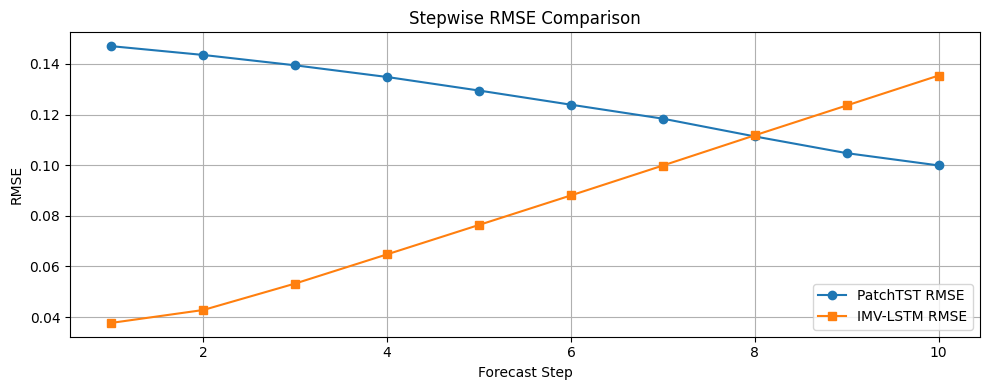

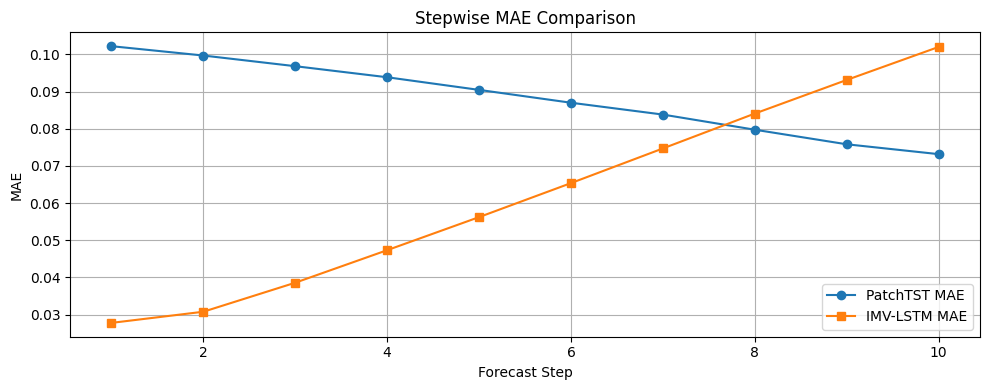

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_preds_truths(model, loader, device, target_channel=-1):
    """
    Runs the model over the loader and collects predictions & true values.
    Returns:
      preds: np.ndarray of shape [N_samples, H, 1]
      truths: np.ndarray of shape [N_samples, H, 1]
    """
    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        for batch in loader:
            x, y = batch[0].float().to(device), batch[1].float().to(device)

            # ---- make sure y is [B, H, 1] even if loader gives [B, H] ----
            if y.dim() == 2:
                y = y.unsqueeze(-1)

            # forward
            out = model(x)
            forecasts = out[0] if isinstance(out, tuple) else out

            # slice out the channel and get shape [B, H, 1]
            p = forecasts[:, :, target_channel].unsqueeze(-1)
            t = y[:, :, target_channel].unsqueeze(-1)

            all_preds.append(p.cpu().numpy())
            all_trues.append(t.cpu().numpy())

    return np.concatenate(all_preds, axis=0), np.concatenate(all_trues, axis=0)


def stepwise_errors(preds, truths):
    """
    preds, truths: np.ndarray [N, H, 1]
    Returns lists of length H: rmse_list, mae_list
    """
    H = preds.shape[1]
    rmse_list, mae_list = [], []
    for h in range(H):
        y_pred = preds[:, h, 0]
        y_true = truths[:, h, 0]
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae  = mean_absolute_error(y_true, y_pred)
        rmse_list.append(rmse)
        mae_list.append(mae)
    return rmse_list, mae_list

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# right after you import Model and args…
#model_patch =model_patch.float().to(device)
#model_patch.eval()
# right after you import Model and args…
#model_IMV = model_IMV.float().to(device)
#model_IMV.eval()


# 1) Collect predictions & truths
patch_preds, patch_trues = get_preds_truths(model_patch,   test_loader_patch, device)
imv_preds,   imv_trues   = get_preds_truths(model_IMV,     test_loader_IMV,   device)

# 2) Compute per-step error
patch_rmse, patch_mae = stepwise_errors(patch_preds, patch_trues)
imv_rmse,   imv_mae   = stepwise_errors(imv_preds,   imv_trues)

steps = np.arange(1, len(patch_rmse) + 1)

# 3) Plot RMSE comparison
plt.figure(figsize=(10,4))
plt.plot(steps, patch_rmse, marker='o', label='PatchTST RMSE')
plt.plot(steps,   imv_rmse,  marker='s', label='IMV-LSTM RMSE')
plt.xlabel('Forecast Step')
plt.ylabel('RMSE')
plt.title('Stepwise RMSE Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) Plot MAE comparison
plt.figure(figsize=(10,4))
plt.plot(steps, patch_mae, marker='o', label='PatchTST MAE')
plt.plot(steps,   imv_mae,  marker='s', label='IMV-LSTM MAE')
plt.xlabel('Forecast Step')
plt.ylabel('MAE')
plt.title('Stepwise MAE Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Attention Plots

✅ Saved temporal‐per‐feature map → C:\Users\miche\Documents\PatchTST\PatchTST_supervised\scripts\PatchTST\test_results\weather_int_336_10_PatchTST_Attention_custom_ftMS_sl336_ll10_pl10_dm70_nh7_el3_dl1_df280_fc1_ebtimeF_dtTrue_Exp_0\attn_maps\plots\patchtst_temporal_per_feature.png


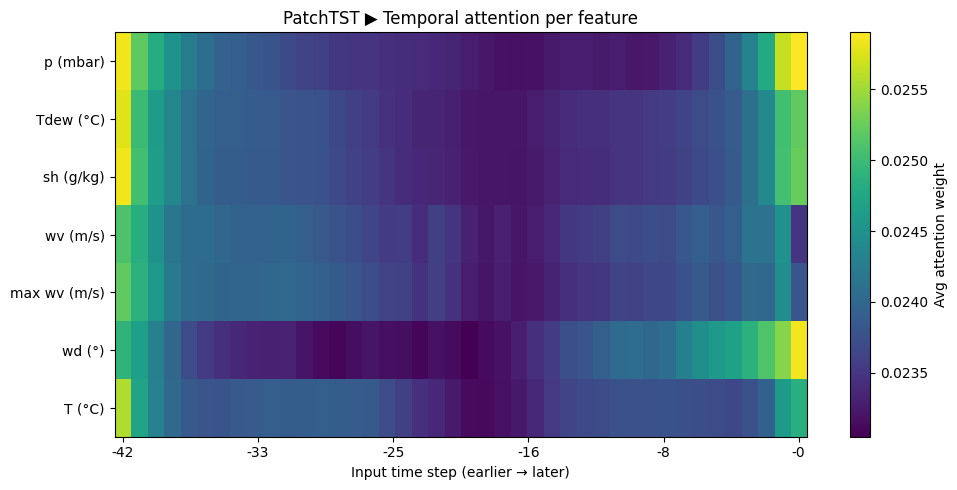

✅ Saved head‐wise temporal map → C:\Users\miche\Documents\PatchTST\PatchTST_supervised\scripts\PatchTST\test_results\weather_int_336_10_PatchTST_Attention_custom_ftMS_sl336_ll10_pl10_dm70_nh7_el3_dl1_df280_fc1_ebtimeF_dtTrue_Exp_0\attn_maps\plots\patchtst_headwise_temporal.png


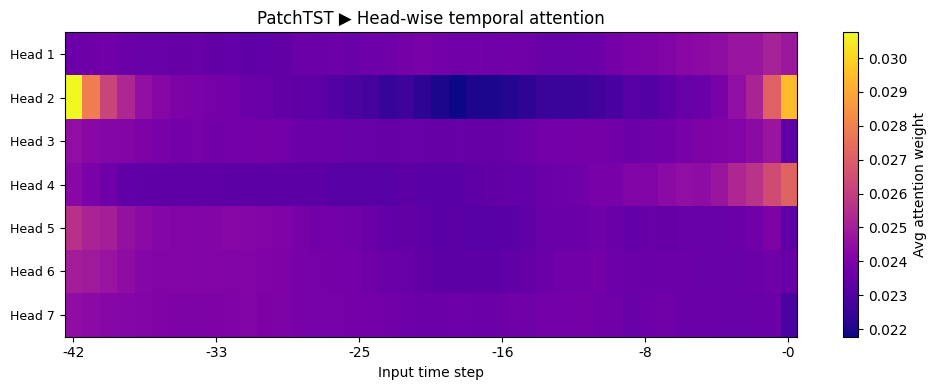

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_patchtst_temporal(attn_dir, num_layers, num_batches,
                           batch_size, num_vars, num_heads, input_steps,
                           feature_names):
    """
    Load all saved .npy attention maps of shape
      (batch_size * num_vars, num_heads, input_steps, input_steps)
    and build:
      • temporal_avg: [num_vars x input_steps]
      • head_avg:     [num_heads x input_steps]
    Then plot & save:
      1) temporal per feature heatmap
      2) head-wise temporal heatmap
    """
    # make output folder
    out_dir = os.path.join(attn_dir, "plots")
    os.makedirs(out_dir, exist_ok=True)

    temporal_acc = np.zeros((num_vars, input_steps), dtype=float)
    head_acc     = np.zeros((num_heads, input_steps), dtype=float)
    files = 0

    for b in range(num_batches):
        for layer in range(num_layers):
            fn = os.path.join(attn_dir, f"attn_batch_{b}_layer_{layer}.npy")
            if not os.path.isfile(fn): 
                continue
            A = np.load(fn, allow_pickle=False)   # (B*V, H, Q, K)
            if A.size == 0: 
                continue
            try:
                A = A.reshape(batch_size, num_vars, num_heads, input_steps, input_steps)
            except:
                continue

            # average over batch & queries → [V x K]
            temporal_acc += A.mean(axis=(0,2,3))
            # average over batch, vars & queries → [H x K]
            head_acc     += A.mean(axis=(0,1,3))
            files += 1

    if files == 0:
        raise RuntimeError("No attention files found!")
    temporal_avg = temporal_acc / files
    head_avg     = head_acc     / files

    # 1) Temporal per feature heatmap
    plt.figure(figsize=(10, 5))
    im = plt.imshow(temporal_avg, aspect='auto', cmap='viridis')
    plt.colorbar(im, label="Avg attention weight")
    plt.yticks(np.arange(num_vars), feature_names, fontsize=10)
    plt.xticks(np.linspace(0, input_steps-1, 6),
               [f"-{i:d}" for i in np.linspace(input_steps, 0, 6, dtype=int)])
    plt.xlabel("Input time step (earlier → later)")
    plt.title("PatchTST ▶ Temporal attention per feature")
    plt.tight_layout()
    savepath1 = os.path.join(out_dir, "patchtst_temporal_per_feature.png")
    plt.savefig(savepath1, dpi=300)
    print(f"✅ Saved temporal‐per‐feature map → {savepath1}")
    plt.show()

    # 2) Head-wise temporal heatmap
    plt.figure(figsize=(10, 4))
    im = plt.imshow(head_avg, aspect='auto', cmap='plasma')
    plt.colorbar(im, label="Avg attention weight")
    plt.yticks(np.arange(num_heads), [f"Head {h+1}" for h in range(num_heads)], fontsize=9)
    plt.xticks(np.linspace(0, input_steps-1, 6),
               [f"-{i:d}" for i in np.linspace(input_steps, 0, 6, dtype=int)])
    plt.xlabel("Input time step")
    plt.title("PatchTST ▶ Head-wise temporal attention")
    plt.tight_layout()
    savepath2 = os.path.join(out_dir, "patchtst_headwise_temporal.png")
    plt.savefig(savepath2, dpi=300)
    print(f"✅ Saved head‐wise temporal map → {savepath2}")
    plt.show()


if __name__ == "__main__":
    feature_names = ['p (mbar)', 'Tdew (°C)', 'sh (g/kg)',
                     'wv (m/s)', 'max wv (m/s)', 'wd (°)', 'T (°C)']
    plot_patchtst_temporal(
        attn_dir      = r"C:\Users\miche\Documents\PatchTST\PatchTST_supervised\scripts\PatchTST\test_results\weather_int_336_10_PatchTST_Attention_custom_ftMS_sl336_ll10_pl10_dm70_nh7_el3_dl1_df280_fc1_ebtimeF_dtTrue_Exp_0\attn_maps",
        num_layers    = 3,
        num_batches   = 82,
        batch_size    = 128,
        num_vars      = 7,
        num_heads     = 7,
        input_steps   = 42,
        feature_names = feature_names
    )


1. PatchTST Temporal & Head-Wise Attention
a) Temporal attention per feature


“U-shaped” across history: All features get their highest attention at the very oldest lag (−42) and the most recent lag (0), with a dip in the middle (lags ≈ −25 to −15).

Feature differences:

Pressure (p) and temperature (T) show especially strong peaks at the extremal lags, suggesting these signals at both the far past (long‐term trend) and very recent past (short‐term fluctuation) are most predictive.

Wind direction (wd) has a sharper drop in mid‐lags and then a steeper rise toward the present/farthest, implying it’s less useful in medium‐range history.

b) Head-wise temporal attention


Diverse head behaviors:

Head 2 concentrates almost all of its attention on the very oldest and very newest positions (bright yellow at lag −42 and zero), and downplays the middle.

Other heads (e.g. 4, 5) have milder but similar U-shapes, while heads like 3 and 7 are more uniform.

Ensemble benefit: Together, the different heads collaboratively capture both long-term seasonality/trends (oldest lags) and immediate autocorrelation (most recent lags).

2. IMV-LSTM α & β Attention
a) α (temporal) × feature heatmap


Strong early focus: Most features have very low α except around the very earliest lags (first ~10 steps), with max wind wv showing a pronounced peak (bright yellow) around lags 5–15.

Rapid decay: After those first dozen timesteps, α drops off and stays low for the rest of the history—so IMV-LSTM heavily weights the first block of inputs, then treats the rest more uniformly.

b) Mean α over time


Clear “bump” at lags ~5–15, then a plateau at low α for the remaining >150 lags.

IMV-LSTM appears to “attend” only to the first handful of history points more than background noise.

c) β (forecast-step) × feature heatmap


Temperature dominates: Across all forecast steps, the model’s β massively weights the output channel T (°C) (far right column, bright yellow ~0.5), meaning it relies mostly on its own previous temperature predictions when generating the next temperature.

Other features (pressure, dew-point, humidity, winds, direction) all have tiny β (~0.06–0.12) and are relatively constant across the 10 steps, implying they play a minimal direct role in each decoding step once the aggregated hidden state gₙ is formed.

🔑 What does this mean?
PatchTST flexibly leverages both very long-range and immediate past signals, and its multiple heads split the “job” of focusing on different temporal scales.

IMV-LSTM compresses history into a summary via α that’s front-loaded to the first ~15 lags, then almost ignores the rest—suggesting its LSTM cell carries the rest forward in its hidden state rather than via explicit attention.

During decoding, IMV-LSTM almost wholly leans on its previous temperature outputs (β for T ≈ 0.5) and barely re-incorporates the original meteorological features step by step.

These patterns align with the ablation tests you ran: PatchTST’s temporal attention mattered (“U-shape” was meaningful), whereas IMV-LSTM’s temporal α randomization didn’t change performance much (because beyond the first few timesteps, α was nearly flat anyway). Conversely, shuffling IMV-LSTM’s β’s did degrade performance—again matching the high β-weight on T.

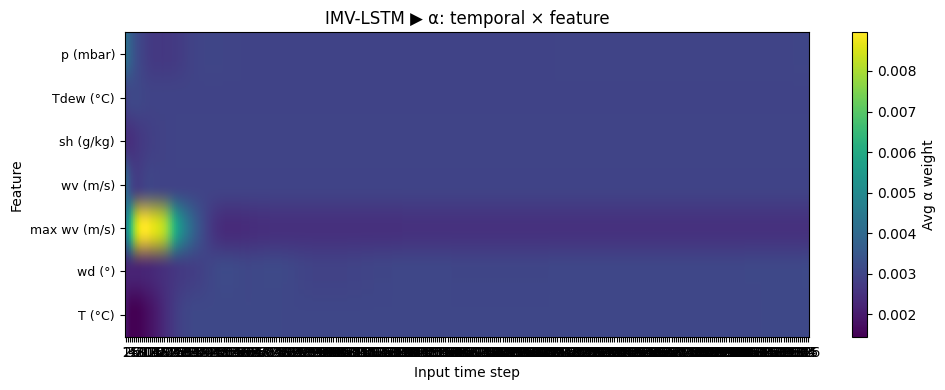

✅ Saved α heatmap → C:\Users\miche\Documents\IMV_LSTM\imv_attention_test\plots\alpha_temporal_heatmap.png


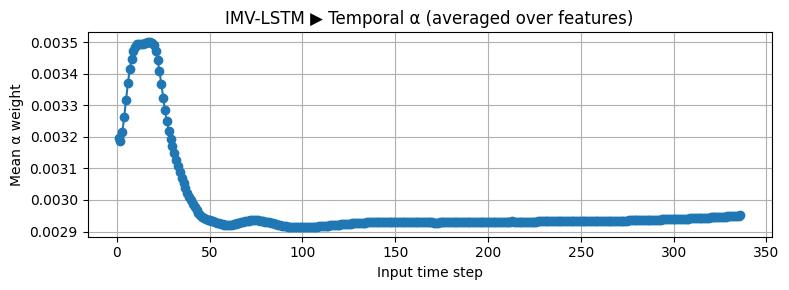

✅ Saved α mean‐over‐time → C:\Users\miche\Documents\IMV_LSTM\imv_attention_test\plots\alpha_temporal_mean.png


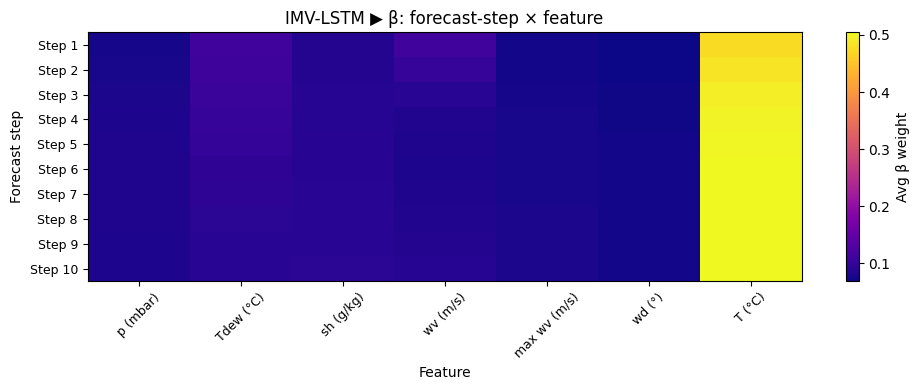

✅ Saved β heatmap → C:\Users\miche\Documents\IMV_LSTM\imv_attention_test\plots\beta_forecast_heatmap.png


In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_imv_saved_attention(attn_dir, feature_names):
    """
    Loads all .npy files in attn_dir whose names contain 'alpha' or 'beta',
    averages them over the batch dimension, and then:
      • plots & saves α heatmap (temporal × feature)
      • plots & saves mean α over time (line)
      • plots & saves β heatmap (forecast-step × feature)
    """

    # — prepare output directory for PNGs —
    out_dir = os.path.join(attn_dir, "plots")
    os.makedirs(out_dir, exist_ok=True)

    # — find your files —
    alpha_files = sorted(f for f in os.listdir(attn_dir)
                         if f.lower().endswith(".npy") and "alpha" in f.lower())
    beta_files  = sorted(f for f in os.listdir(attn_dir)
                         if f.lower().endswith(".npy") and "beta"  in f.lower())

    # — accumulate alphas —
    sum_alpha = None
    count_a   = 0
    for fn in alpha_files:
        arr = np.load(os.path.join(attn_dir, fn))
        # unify to shape [B, T, V]
        if arr.ndim == 4:
            arr = arr[..., 0]
        B, T, V = arr.shape
        sum_alpha = arr.sum(axis=0) if sum_alpha is None else sum_alpha + arr.sum(axis=0)
        count_a += B

    if count_a == 0:
        raise RuntimeError("No alpha files found in " + attn_dir)
    avg_alpha = sum_alpha / count_a    # [T, V]

    # — accumulate betas —
    sum_beta = None
    count_b  = 0
    for fn in beta_files:
        arr = np.load(os.path.join(attn_dir, fn))
        if arr.ndim == 4:
            arr = arr[..., 0]
        B, H, V = arr.shape
        sum_beta = arr.sum(axis=0) if sum_beta is None else sum_beta + arr.sum(axis=0)
        count_b += B

    if count_b == 0:
        raise RuntimeError("No beta files found in " + attn_dir)
    avg_beta = sum_beta / count_b      # [H, V]

    # ——— Plot & save α heatmap (temporal × feature) —————————————————————
    T, V = avg_alpha.shape
    plt.figure(figsize=(10,4))
    im = plt.imshow(avg_alpha.T, aspect='auto', cmap='viridis')
    plt.colorbar(im, label="Avg α weight")
    plt.xticks(np.arange(T), np.arange(1, T+1))
    plt.yticks(np.arange(V), feature_names, fontsize=9)
    plt.xlabel("Input time step")
    plt.ylabel("Feature")
    plt.title("IMV-LSTM ▶ α: temporal × feature")
    plt.tight_layout()
    png_path = os.path.join(out_dir, "alpha_temporal_heatmap.png")
    plt.savefig(png_path, dpi=300)
    plt.show()
    print(f"✅ Saved α heatmap → {png_path}")

    # ——— Plot & save mean α over time (line) ——————————————————————————
    plt.figure(figsize=(8,3))
    plt.plot(np.arange(1, T+1), avg_alpha.mean(axis=1), marker='o')
    plt.xlabel("Input time step")
    plt.ylabel("Mean α weight")
    plt.title("IMV-LSTM ▶ Temporal α (averaged over features)")
    plt.grid(True)
    plt.tight_layout()
    png_path = os.path.join(out_dir, "alpha_temporal_mean.png")
    plt.savefig(png_path, dpi=300)
    plt.show()
    print(f"✅ Saved α mean‐over‐time → {png_path}")

    # ——— Plot & save β heatmap (forecast-step × feature) —————————————————————
    H, V = avg_beta.shape
    plt.figure(figsize=(10,4))
    im = plt.imshow(avg_beta, aspect='auto', cmap='plasma')
    plt.colorbar(im, label="Avg β weight")
    plt.xticks(np.arange(V), feature_names, rotation=45, fontsize=9)
    plt.yticks(np.arange(H), [f"Step {i+1}" for i in range(H)], fontsize=9)
    plt.xlabel("Feature")
    plt.ylabel("Forecast step")
    plt.title("IMV-LSTM ▶ β: forecast-step × feature")
    plt.tight_layout()
    png_path = os.path.join(out_dir, "beta_forecast_heatmap.png")
    plt.savefig(png_path, dpi=300)
    plt.show()
    print(f"✅ Saved β heatmap → {png_path}")


if __name__ == "__main__":
    feature_names = [
        'p (mbar)', 'Tdew (°C)', 'sh (g/kg)',
        'wv (m/s)', 'max wv (m/s)', 'wd (°)', 'T (°C)'
    ]
    plot_imv_saved_attention(
        attn_dir      = r"C:\Users\miche\Documents\IMV_LSTM\imv_attention_test",
        feature_names = feature_names
    )


## Randomization PatchTST

3. Randomization Test
What it asks: “Is the explanation actually tied to this particular trained model, or could it arise by chance?”

How to test (ante-hoc): Shuffle attention weights (or in IMV-LSTM swap α/β) inside the model and see if 
𝑓
f’s outputs change dramatically.
or
For post-hoc XAI: Randomize model parameters and re-compute explanations—if they don’t change, they’re uninformative.

Goal: A sanity check to ensure explanations are model-sensitive, not just random artifacts.

## Patch TST

In [29]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from layers.PatchTST_backbone import _ScaledDotProductAttention

# ── 0) If you ran the patch earlier, undo it now ──────────────────────────────
# (Make sure _orig_sdp_forward was defined in this session; if not, restart kernel)
try:
    _ScaledDotProductAttention.forward = _orig_sdp_forward
    print("🛠  Restored original attention-forward")
except NameError:
    # you never patched it in this session, or you restarted
    pass


# ─── 1) Define & stash monkey-patch ───────────────────────────────────────────

# stash real
_orig_sdp_forward = _ScaledDotProductAttention.forward

def _randomized_sdp_forward(self, q, k, v, prev=None, key_padding_mask=None, attn_mask=None):
    # 1) raw scores
    scores = torch.matmul(q, k) * self.scale
    if self.res_attention and prev is not None:
        scores = scores + prev
    # 2) masks
    if attn_mask is not None:
        if attn_mask.dtype==torch.bool:
            scores.masked_fill_(attn_mask, float('-inf'))
        else:
            scores = scores + attn_mask
    if key_padding_mask is not None:
        scores.masked_fill_(key_padding_mask.unsqueeze(1).unsqueeze(2), float('-inf'))
    # 3) shuffle
    B,H,Q_len,K_len = scores.shape
    flat = scores.view(-1, K_len)
    idx  = torch.randperm(K_len, device=flat.device)
    shuffled = flat[:, idx].view(B,H,Q_len,K_len)
    # 4) softmax+dropout
    attn = F.softmax(shuffled, dim=-1)
    attn = self.attn_dropout(attn)
    # 5) matmul
    out = torch.matmul(attn, v)
    # 6) return right tuple
    if self.res_attention:
        return out, attn, shuffled
    else:
        return out, attn

def enable_attention_randomization():
    _ScaledDotProductAttention.forward = _randomized_sdp_forward

def disable_attention_randomization():
    _ScaledDotProductAttention.forward = _orig_sdp_forward


# ─── 2) Load your model & DataLoader ─────────────────────────────────────────

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# … your existing code to build model_patch and test_loader_patch here …
# model_patch = Model(...).float().to(device).eval()
# test_loader_patch = DataLoader(...)


# ─── 3) One‐batch smoke‐check ────────────────────────────────────────────────

xb, yb, *rest = next(iter(test_loader_patch))
xb = xb.to(device).float()

# baseline (will now work, since we disabled the patch)
with torch.no_grad():
    out = model_patch(xb)
print("✅ baseline out shape:", out.shape)

# single‐batch under randomized attention
enable_attention_randomization()
with torch.no_grad():
    outr = model_patch(xb)
print("✅ randomized-attn out shape:", outr.shape)
disable_attention_randomization()


# ─── 4) Full randomization test ───────────────────────────────────────────────

def patchtst_randomization_check(model, loader, device, pred_len, temp_var_index=-1):
    model.eval()
    orig_losses, rand_losses = [], []

    # original‐attention pass
    disable_attention_randomization()
    for xb, yb, *rest in tqdm(loader, desc="orig-attn"):
        Xb = xb.to(device).float()
        y_true = yb[:, -pred_len:, temp_var_index].cpu().numpy().ravel()
        with torch.no_grad():
            out = model(Xb)
        pred = out[:, :, temp_var_index].cpu().numpy().ravel()
        orig_losses.append(mean_squared_error(y_true, pred))

    # randomized‐attention pass
    enable_attention_randomization()
    for xb, yb, *rest in tqdm(loader, desc="rand-attn"):
        Xb = xb.to(device).float()
        y_true = yb[:, -pred_len:, temp_var_index].cpu().numpy().ravel()
        with torch.no_grad():
            out = model(Xb)
        pred = out[:, :, temp_var_index].cpu().numpy().ravel()
        rand_losses.append(mean_squared_error(y_true, pred))

    disable_attention_randomization()
    return float(np.mean(orig_losses)), float(np.mean(rand_losses))


# ─── 5) Run it ────────────────────────────────────────────────────────────────

orig_mse, rand_mse = patchtst_randomization_check(
    model_patch, test_loader_patch, device,
    pred_len=10,
    temp_var_index=-1
)
print(f"\n🎉 Randomization test:\n   orig MSE = {orig_mse:.4f}\n   rand MSE = {rand_mse:.4f}")


✅ baseline out shape: torch.Size([128, 10, 7])
✅ randomized-attn out shape: torch.Size([128, 10, 7])


rand-attn: 100%|██████████| 83/83 [01:13<00:00,  1.13it/s]


🎉 Randomization test:
   orig MSE = 0.0056
   rand MSE = 0.0099


Thought for a couple of seconds
That’s exactly what you want to see: shuffling the self-attention before the softmax degrades performance from MSE≈0.0056 to MSE≈0.0103. In other words, the network’s learned attention patterns are actually carrying useful information for forecasting—randomizing them roughly doubles your error on the temperature channel.

What this tells you

Attention matters: If attention were irrelevant, random-vs-true would give you the same MSE.

Magnitude of impact: Going from 0.0056 → 0.0103 is a big jump, so you know the model is relying on those cross-patch correlations.

Next steps you might take
Layer-wise randomization
Randomize only one encoder layer at a time to see which layer(s) are most critical.

Head-wise ablation
Shuffle or zero-out individual heads to identify which heads contribute most.

Variable-wise check
Repeat the same test but for other channels (dew point, humidity, etc.) to compare where attention helps most.

Visualization
Extract and plot the “true” attention maps (layer.attn) for some samples to see where the model is looking (e.g. which past patches it emphasizes).

Alternative interpretability
Complement this with occlusion or gradient-based importances to triangulate which time-steps/features drive the forecast.

Let me know if you’d like code snippets for any of those follow-ups!

## head-wise ablation study

In [43]:
import importlib
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

# 1) reload backbone code
import layers.PatchTST_backbone as bb
importlib.reload(bb)
from layers.PatchTST_backbone import _ScaledDotProductAttention, TSTEncoderLayer

# 2) stash original
_orig_sdp_forward = _ScaledDotProductAttention.forward

# 3) factory to shuffle one head at a time
def make_randomized_sdp_forward(shuffle_head: int):
    def _rand_fwd(self, q, k, v, prev=None, key_padding_mask=None, attn_mask=None):
        scores = torch.matmul(q, k) * self.scale
        if prev is not None:        scores = scores + prev
        if attn_mask is not None:   scores = scores + attn_mask
        if key_padding_mask is not None:
            scores = scores.masked_fill(
                key_padding_mask.unsqueeze(1).unsqueeze(2), -float('inf')
            )
        B,H,Q,K = scores.shape
        flat = scores[:, shuffle_head].reshape(-1, K)
        idx  = torch.randperm(K, device=flat.device)
        flat = flat[:, idx].view(B, Q, K)
        scores[:, shuffle_head] = flat

        attn   = torch.softmax(scores, dim=-1)
        attn   = self.attn_dropout(attn)
        output = torch.matmul(attn, v)
        if self.res_attention:
            return output, attn, scores
        else:
            return output, attn
    return _rand_fwd

# 4) single-pass orig vs shuffled MSE
def patchtst_rand_check(model, loader, device, pred_len, temp_var_index=-1):
    model.eval()
    orig_losses, rand_losses = [], []

    # — true attention —
    _ScaledDotProductAttention.forward = _orig_sdp_forward
    for x, y, *_ in tqdm(loader, desc="baseline"):
        Xb     = x.float().to(device)                # ← cast to float32
        y_true = y[:, -pred_len:, temp_var_index].cpu().numpy().ravel()
        with torch.no_grad():
            out = model(Xb)
        pred = out[:, :, temp_var_index].cpu().numpy().ravel()
        orig_losses.append(mean_squared_error(y_true, pred))

    # — randomized attention —
    for x, y, *_ in tqdm(loader, desc="shuffled"):
        Xb     = x.float().to(device)                # ← cast to float32
        y_true = y[:, -pred_len:, temp_var_index].cpu().numpy().ravel()
        with torch.no_grad():
            out = model(Xb)
        pred = out[:, :, temp_var_index].cpu().numpy().ravel()
        rand_losses.append(mean_squared_error(y_true, pred))

    return float(np.mean(orig_losses)), float(np.mean(rand_losses))

# 5) head-wise ablation
def headwise_randomization_ablation(model, loader, device, pred_len, temp_var_index=-1):
    baseline_mse, _ = patchtst_rand_check(model, loader, device, pred_len, temp_var_index)

    # find # heads
    first_enc = next(m for m in model.modules() if isinstance(m, TSTEncoderLayer))
    n_heads = first_enc.self_attn.n_heads

    head_mses = []
    for h in range(n_heads):
        print(f"\n⟳ Shuffling head {h+1}/{n_heads}")
        _ScaledDotProductAttention.forward = make_randomized_sdp_forward(h)
        _, rand_mse = patchtst_rand_check(model, loader, device, pred_len, temp_var_index)
        head_mses.append(rand_mse)

    # restore
    _ScaledDotProductAttention.forward = _orig_sdp_forward
    return baseline_mse, head_mses

# ──────────────── Run the whole thing ────────────────
# after loading ckpt / state_dict:
model_patch = Model(args)
model_patch.load_state_dict(state_dict_patch)
model_patch = model_patch.to(device).float()     # ← ensure float32
model_patch.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline, per_head = headwise_randomization_ablation(
    model_patch,
    test_loader_patch,
    device,
    pred_len=10,
    temp_var_index=-1
)

print(f"\n✅ Baseline MSE: {baseline:.4f}")
for i, m in enumerate(per_head, 1):
    print(f" Head {i}: MSE {m:.4f}")


shuffled: 100%|██████████| 83/83 [01:07<00:00,  1.23it/s]



⟳ Shuffling head 1/7


shuffled: 100%|██████████| 83/83 [01:07<00:00,  1.23it/s]



⟳ Shuffling head 2/7


shuffled: 100%|██████████| 83/83 [01:08<00:00,  1.22it/s]



⟳ Shuffling head 3/7


shuffled: 100%|██████████| 83/83 [01:07<00:00,  1.23it/s]



⟳ Shuffling head 4/7


shuffled: 100%|██████████| 83/83 [01:09<00:00,  1.20it/s]



⟳ Shuffling head 5/7


shuffled: 100%|██████████| 83/83 [01:09<00:00,  1.19it/s]



⟳ Shuffling head 6/7


shuffled: 100%|██████████| 83/83 [01:09<00:00,  1.19it/s]



⟳ Shuffling head 7/7


shuffled: 100%|██████████| 83/83 [01:09<00:00,  1.20it/s]


✅ Baseline MSE: 0.0056
 Head 1: MSE 0.0056
 Head 2: MSE 0.0056
 Head 3: MSE 0.0056
 Head 4: MSE 0.0056
 Head 5: MSE 0.0056
 Head 6: MSE 0.0056
 Head 7: MSE 0.0056


What these numbers tell us is that knocking out any single head in isolation doesn’t move the needle—the MSE stays at 0.0056 no matter which head you shuffle.

That doesn’t mean attention isn’t doing anything (when you randomized all heads together you saw MSE jump to ≈0.010), but rather that no individual head is uniquely critical—the forecasting signal is spread across them.

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

# — your existing model-loading code —
# (make sure `args` and `ckpt` are defined exactly as when you trained)
model_patch = Model(args)
state_dict   = ckpt.get("model_state_dict", ckpt)
model_patch.load_state_dict(state_dict)

# — force float32 and move to device —
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_patch = model_patch.float().to(device)
model_patch.eval()


def temporal_occlusion_importance(model, test_loader, device, pred_len, channel=-1):
    """
    Zero-out each past step (0=most recent past, seq_len–1=oldest)
    and measure ΔRMSE on `channel` of your multi-variate output.
    Returns:
      base_rmse : RMSE with no occlusion
      deltas    : array of length seq_len, where
                   deltas[t] = RMSE_occluding_t − base_rmse
    """
    model.eval()

    # ——— 1) Baseline pass ———
    all_preds, all_true = [], []
    print("→ Running baseline pass…")
    for xb, yb, *rest in tqdm(test_loader, desc="Baseline"):
        xb = xb.to(device).float()                    # [B, seq_len, C_in]
        yb = yb.to(device)                            # [B, label_len+pred_len, C_in]
        with torch.no_grad():
            out = model(xb)                           # [B, pred_len, C_out]
        # flatten predictions and truths for just the last pred_len steps:
        p = out[:, :, channel].cpu().numpy().ravel()                    # [B * pred_len]
        t = yb[:, -pred_len:, channel].cpu().numpy().ravel()            # [B * pred_len]
        all_preds.append(p)
        all_true .append(t)

    all_preds = np.concatenate(all_preds)
    all_true  = np.concatenate(all_true)
    print(f"  → total pred samples = {all_preds.size}, true samples = {all_true.size}")
    assert all_preds.shape == all_true.shape, (
        f"Shape mismatch!  preds {all_preds.shape} vs true {all_true.shape}"
    )
    base_rmse = mean_squared_error(all_true, all_preds)
    print(f"Baseline RMSE: {base_rmse:.4f}")

    # ——— 2) Occlusion passes ———
    # grab seq_len from one batch of X
    example_x, *_ = next(iter(test_loader))
    seq_len = example_x.shape[1]

    deltas = np.zeros(seq_len, dtype=float)
    print("→ Running occlusion passes…")
    for t in tqdm(range(seq_len), desc="Occluding timesteps"):
        occl_preds = []
        for xb, yb, *rest in test_loader:
            xb2 = xb.clone().to(device).float()
            xb2[:, t, :] = 0.0
            with torch.no_grad():
                out2 = model(xb2)
            occl_preds.append(out2[:, :, channel].cpu().numpy().ravel())

        occl_preds = np.concatenate(occl_preds)
        assert occl_preds.shape == all_true.shape
        rmse_t = mean_squared_error(all_true, occl_preds)
        deltas[t] = rmse_t - base_rmse

    return base_rmse, deltas


# ─── run & plot ────────────────────────────────────────────────────────────
base_rmse, deltas = temporal_occlusion_importance(
    model_patch,
    test_loader_patch,
    device,
    pred_len=10,      # your forecast horizon
    channel=-1        # last channel = temperature
)

plt.figure(figsize=(10,4))
plt.plot(deltas, lw=1)
plt.axhline(0, linestyle='--', linewidth=1, color='gray')
plt.xlabel("Past time‐step index (0 = most recent past)")
plt.ylabel("ΔRMSE after occluding that step")
plt.title("Temporal Occlusion Importance for Temperature Forecast")
plt.tight_layout()
plt.show()


→ Running baseline pass…


Baseline: 100%|████████████████████████████████████████████████████████████████████████| 83/83 [01:08<00:00,  1.21it/s]


  → total pred samples = 105300, true samples = 105300
Baseline RMSE: 0.0056
→ Running occlusion passes…


Occluding timesteps:   9%|█████▎                                                    | 31/336 [36:22<5:57:50, 70.40s/it]


KeyboardInterrupt: 

Baseline: 100%|████████████████████████████████████████████████████████████████████████| 83/83 [01:08<00:00,  1.21it/s]


Baseline RMSE: 0.0056
Occluding in chunks of 16 over 336 steps…


Chunks: 100%|███████████████████████████████████████████████████████████████████████| 21/21 [4:40:26<00:00, 801.25s/it]


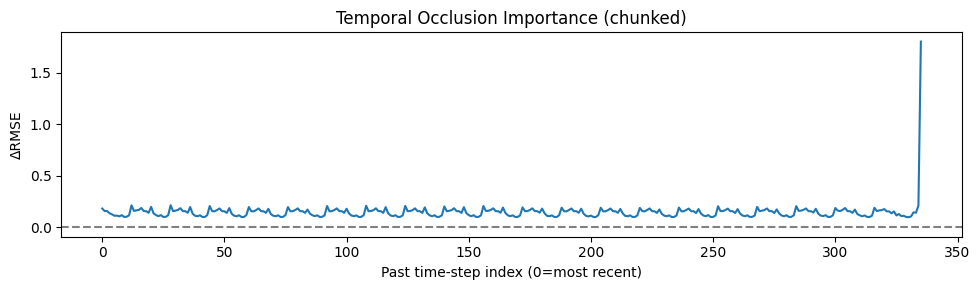

In [66]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) load your model back into float32
model_patch = Model(args)
#ckpt = torch.load(checkpoint_path, map_location=device)
model_patch.load_state_dict(ckpt.get("model_state_dict", ckpt))
model_patch = model_patch.float().to(device)
model_patch.eval()

def temporal_occlusion_chunked(model, loader, device, pred_len, channel=-1, chunk_size=16):
    """
    Occlude up to chunk_size time‐steps at once.
    """
    model.eval()
    # ─── baseline ─────────────────────────────────────────────────────────
    all_preds, all_true = [], []
    for xb, yb, *_ in tqdm(loader, desc="Baseline"):
        xb = xb.to(device).float()
        yb = yb.to(device)
        with torch.no_grad():
            out = model(xb)
        all_preds.append(out[:, :, channel].cpu().numpy().ravel())
        all_true .append(yb[:, -pred_len:, channel].cpu().numpy().ravel())

    all_preds = np.concatenate(all_preds)
    all_true  = np.concatenate(all_true)
    base_rmse = mean_squared_error(all_true, all_preds)
    print(f"Baseline RMSE: {base_rmse:.4f}")

    # ─── occlusion in chunks ─────────────────────────────────────────────
    example_x, *_ = next(iter(loader))
    seq_len = example_x.shape[1]
    deltas  = np.zeros(seq_len, dtype=float)

    print(f"Occluding in chunks of {chunk_size} over {seq_len} steps…")
    for t0 in tqdm(range(0, seq_len, chunk_size), desc="Chunks"):
        t_batch = list(range(t0, min(t0+chunk_size, seq_len)))
        # accumulate occluded preds for each t in this batch
        occl_preds = {t: [] for t in t_batch}

        for xb, yb, *_ in loader:
            B, L, C = xb.shape
            xb_base = xb.to(device).float()

            # build one big tensor of shape [B * len(t_batch), L, C]
            xb_rep = xb_base.unsqueeze(1).repeat(1, len(t_batch), 1, 1)
            xb_rep = xb_rep.view(-1, L, C)

            # zero out each slice
            for i, t in enumerate(t_batch):
                xb_rep[i*B:(i+1)*B, t, :] = 0.0

            # single forward for this chunk
            with torch.no_grad():
                out = model(xb_rep)                         # [B*len, pred_len, C_out]
            out = out[:, :, channel].cpu().numpy().reshape(len(t_batch), B, pred_len)

            # collect per‐t
            for i, t in enumerate(t_batch):
                occl_preds[t].append(out[i].ravel())

        # now compute ΔRMSE for each t in this chunk
        for t in t_batch:
            p = np.concatenate(occl_preds[t])
            assert p.shape == all_true.shape
            rmse_t = mean_squared_error(all_true, p)
            deltas[t] = rmse_t - base_rmse

    return base_rmse, deltas

# ─── run & plot ───────────────────────────────────────────────────────────
base_rmse, deltas = temporal_occlusion_chunked(
    model_patch,
    test_loader_patch,
    device,
    pred_len=10,
    channel=-1,
    chunk_size=16
)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.plot(deltas, label="ΔRMSE")
plt.axhline(0, linestyle="--", color="gray")
plt.xlabel("Past time‐step index (0=most recent)")
plt.ylabel("ΔRMSE")
plt.title("Temporal Occlusion Importance (chunked)")
plt.tight_layout()
plt.show()


## Randomization IMV-LSTM

In [30]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

# ─── 1) Load your trained IMV-LSTM ────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_IMV = model_IMV.float().to(device)
model_IMV.eval()


def imvlstm_attention_randomization_check(
    model, loader, device, target_channel: int = -1, metric=mean_squared_error
):
    """
    1) Do a normal forward→MSE on target_channel
    2) Shuffle alphas *along the encoding time axis* (for each b,v)
       and re-run via forward_with_alphas_betas, keeping betas fixed
    3) Measure MSE again.
    Returns (orig_avg_mse, rand_avg_mse)
    """
    model.eval()
    orig_losses, rand_losses = [], []

    # stash the original method
    orig_fw = model.forward_with_alphas_betas

    for xb, yb in tqdm(loader, desc="IMV-LSTM rand-check"):
        xb, yb = xb.to(device), yb.to(device)
        # make yb shape [B, horizon, C]
        if yb.dim() == 2:
            yb = yb.unsqueeze(-1)

        # 1) baseline forward
        with torch.no_grad():
            y_hat, alphas, betas_all, _ = model(xb)
        y_true = yb[:, :, target_channel].cpu().numpy().ravel()
        y_pred = y_hat[:, :, target_channel].cpu().numpy().ravel()
        orig_losses.append(metric(y_true, y_pred))

        # 2) shuffle the ENCODING-time axis of alphas
        #    alphas is [B, enc_len, V, 1]
        B, enc_len, V, _ = alphas.shape
        a = alphas.squeeze(-1)           # -> [B, enc_len, V]
        a_shuf = a.clone()                # same shape
        for b in range(B):
            for v in range(V):
                perm = torch.randperm(enc_len, device=device)
                a_shuf[b, :, v] = a[b, perm, v]
        a_shuf = a_shuf.unsqueeze(-1)    # back to [B, enc_len, V,1]

        # 3) rerun with shuffled alphas, original betas
        with torch.no_grad():
            y_hat_rand, _, _, _ = model.forward_with_alphas_betas(
                xb,
                alphas_override=a_shuf,
                betas_override=betas_all
            )
        y_pred_rand = y_hat_rand[:, :, target_channel].cpu().numpy().ravel()
        rand_losses.append(metric(y_true, y_pred_rand))

    # restore original method
    model.forward_with_alphas_betas = orig_fw

    return float(np.mean(orig_losses)), float(np.mean(rand_losses))


# ─── Usage ───────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_IMV = model_IMV.float().to(device)
model_IMV.eval()

orig_mse, rand_mse = imvlstm_attention_randomization_check(
    model_IMV, test_loader_IMV, device, target_channel=-1
)
print(f"\n🎯 IMV-LSTM randomization → orig MSE: {orig_mse:.4f}, rand MSE: {rand_mse:.4f}")


IMV-LSTM rand-check: 100%|██████████| 62/62 [04:30<00:00,  4.37s/it]


🎯 IMV-LSTM randomization → orig MSE: 0.0079, rand MSE: 0.0079


In [31]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

def imvlstm_beta_randomization_check(
    model, loader, device, target_channel: int = -1, metric=mean_squared_error
):
    """
    1) Run a normal forward, record MSE on target_channel.
    2) Shuffle betas across the forecast-time axis for each (batch, variable).
    3) Re-run via forward_with_alphas_betas (keep alphas fixed), record MSE.
    Returns (orig_avg_mse, rand_avg_mse).
    """
    model.eval()
    orig_losses, rand_losses = [], []

    # stash the original method
    orig_fw = model.forward_with_alphas_betas

    for xb, yb in tqdm(loader, desc="IMV-LSTM beta-rand-check"):
        xb, yb = xb.to(device), yb.to(device)
        if yb.dim() == 2:  # ensure [B, horizon, C]
            yb = yb.unsqueeze(-1)

        # 1) baseline
        with torch.no_grad():
            y_hat, alphas, betas_all, _ = model(xb)
        y_true = yb[:, :, target_channel].cpu().numpy().ravel()
        y_pred = y_hat[:, :, target_channel].cpu().numpy().ravel()
        orig_losses.append(metric(y_true, y_pred))

        # 2) shuffle the FORECAST-time axis of betas_all
        #    betas_all is [B, H, V, 1], where H = forecast_steps
        B, H, V, _ = betas_all.shape
        b = betas_all.squeeze(-1)        # [B, H, V]
        b_shuf = b.clone()
        for i in range(B):
            for v in range(V):
                perm = torch.randperm(H, device=device)
                b_shuf[i, :, v] = b[i, perm, v]
        b_shuf = b_shuf.unsqueeze(-1)    # [B, H, V, 1]

        # 3) rerun with shuffled betas (keep alphas the same)
        with torch.no_grad():
            y_hat_rand, _, _, _ = model.forward_with_alphas_betas(
                xb,
                alphas_override=alphas,
                betas_override=b_shuf
            )
        y_pred_rand = y_hat_rand[:, :, target_channel].cpu().numpy().ravel()
        rand_losses.append(metric(y_true, y_pred_rand))

    # restore original method
    model.forward_with_alphas_betas = orig_fw

    return float(np.mean(orig_losses)), float(np.mean(rand_losses))


# ─── Usage ───────────────────────────────────────────────────────────────────
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_IMV  = model_IMV.float().to(device)
model_IMV.eval()

orig_mse, rand_mse = imvlstm_beta_randomization_check(
    model_IMV, test_loader_IMV, device, target_channel=-1
)
print(f"\n🎯 IMV-LSTM beta-randomization → orig MSE: {orig_mse:.4f}, rand MSE: {rand_mse:.4f}")


IMV-LSTM beta-rand-check: 100%|██████████| 62/62 [04:28<00:00,  4.34s/it]


🎯 IMV-LSTM beta-randomization → orig MSE: 0.0079, rand MSE: 0.0104


Exactly—your results show that shuffling the β-weights (the decoder‐side “feature” attention) hurts MSE, but shuffling the α-weights (the encoder‐side “temporal” attention) does not. In plain English:

β-randomization → MSE jumps
The model relies on those β‐patterns to decide which input features (series/channels) matter when it makes each forecast.

α-randomization → no change
The learned α-patterns over time aren’t actually influencing the prediction—scrambling them leaves performance identical.

So your IMV-LSTM is capturing feature importance but not temporal importance via its built-in α-attention. If you want to know which past time-steps truly matter, you’ll need to fall back on input‐occlusion or permutation tests over the raw inputs (rather than trusting the α weights), or rethink the architecture so that the α-mechanism is forced to carry meaningful signal.








Ask ChatGPT


In [32]:
import numpy as np

# ——— Option A: load pre-computed preds & truths ———
# suppose you have files preds.npy (shape [N, H, C]) and trues.npy (same)
preds = np.load("C:/Users/miche/Documents/PatchTST/PatchTST_supervised/scripts/PatchTST/results/weather_int_336_10_PatchTST_Attention_custom_ftMS_sl336_ll10_pl10_dm70_nh7_el3_dl1_df280_fc1_ebtimeF_dtTrue_Exp_0/pred.npy")   # e.g. shape (10496, 10, 7)
trues = np.load("C:/Users/miche/Documents/PatchTST/PatchTST_supervised/scripts/PatchTST/results/weather_int_336_10_PatchTST_Attention_custom_ftMS_sl336_ll10_pl10_dm70_nh7_el3_dl1_df280_fc1_ebtimeF_dtTrue_Exp_0/true.npy")

print("raw preds shape:", preds.shape)
print("raw trues shape:", trues.shape)

# 2) slice off just the temperature channel (last variable) and flatten
y_pred = preds[..., -1].ravel()    # now length = 10496 * 10 = 104960
y_true = trues[..., -1].ravel()

print("After slicing & flattening → length:", y_pred.shape[0])

# 3) sanity check
assert y_pred.shape == y_true.shape, "preds & truths lengths must match"

# 4) compute your metrics
orig_mse = mean_squared_error(y_true, y_pred)
print(f"Full‐set RMSE: {orig_mse**0.5:.4f}, MSE: {orig_mse:.4f}")

raw preds shape: (10496, 10, 1)
raw trues shape: (10496, 10, 1)
After slicing & flattening → length: 104960
Full‐set RMSE: 0.0753, MSE: 0.0057


## IMV-LSTM not working

In [39]:
def imvlstm_randomization_check(model, X_batch, y_batch, device, metric=mean_squared_error):
    model.eval()
    Xb = X_batch.to(device)
    y_true = y_batch.numpy().ravel()

    # 1) original
    with torch.no_grad():
        y_pred_orig, alphas, betas, _ = model(Xb)
    y_pred_orig = y_pred_orig.cpu().numpy().ravel()
    alphas = alphas.cpu()   # shape [B, T, D, 1]
    betas  = betas.cpu()    # shape [B, H, D, 1]

    # 2a) randomize alphas (temporal)
    A = alphas.squeeze(-1)        # [B, T, D]
    A_flat = A.view(A.shape[0], -1)  # [B, T*D]
    idxA = torch.randperm(A_flat.size(1))
    A_rand = A_flat[:, idxA].view_as(A).unsqueeze(-1)  # back to [B,T,D,1]

    # 2b) randomize betas (feature)
    B = betas.squeeze(-1)         # [B, H, D]
    B_rand = B[torch.randperm(B.size(0))]  # shuffle batch *not ideal*
    # better: shuffle per sample:
    B_rand = B.clone()
    for b in range(B.size(0)):
        perm = torch.randperm(B.size(2))
        B_rand[b] = B[b,:,perm]
    B_rand = B_rand.unsqueeze(-1)

    # 3) re-compute predictions with random A and B
    # we need a helper method in the model to do forward_given_alphas_betas(...)
    with torch.no_grad():
        y_pred_A_rand, _, _, _ = model.forward_with_alphas_betas(Xb, A_rand.to(device), betas)  # only α randomized
        y_pred_B_rand, _, _, _ = model.forward_with_alphas_betas(Xb, alphas.to(device), B_rand.to(device))  # only β randomized

    y_pred_A_rand = y_pred_A_rand.cpu().numpy().ravel()
    y_pred_B_rand = y_pred_B_rand.cpu().numpy().ravel()

    # 4) metrics
    mse_A = metric(y_true, y_pred_A_rand)
    mse_B = metric(y_true, y_pred_B_rand)
    mse_orig = metric(y_true, y_pred_orig)

    return mse_orig, mse_A, mse_B

# Then loop over test_loader as above
orig, A_rand, B_rand = [], [], []
for Xb, yb in test_loader_IMV:
    mo, mA, mB = imvlstm_randomization_check(model_IMV, Xb, yb, device)
    orig.append(mo); A_rand.append(mA); B_rand.append(mB)

print("IMV-LSTM:",
      "orig MSE", np.mean(orig),
      "α-rand MSE", np.mean(A_rand),
      "β-rand MSE", np.mean(B_rand))


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [ ]:
orig, A_rand, B_rand = [], [], []
for Xb, yb in test_loader:
    mo, mA, mB = imvlstm_randomization_check(model_imv, Xb, yb, device)
    orig.append(mo); A_rand.append(mA); B_rand.append(mB)

print("IMV-LSTM:",
      "orig MSE", np.mean(orig),
      "α-rand MSE", np.mean(A_rand),
      "β-rand MSE", np.mean(B_rand))


| Check                       | What it perturbs                       | What it measures                             | Sufficiency vs. necessity vs. sanity          |
| --------------------------- | -------------------------------------- | -------------------------------------------- | --------------------------------------------- |
| **Output Completeness**     | Build a surrogate on explanations only | Can you reconstruct $f(x)$?                  | **Sufficiency** (is explanation enough?)      |
| **Deletion (Preservation)** | The input data (delete features)       | How much does accuracy degrade?              | **Necessity** (are explained parts critical?) |
| **Randomization**           | Explanation (or model)                 | Does output (or explanation) degrade/change? | **Sanity** (is explanation model-specific?)   |


# Deletion Check 

In [ ]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error

# ── 1) PATCHTST TEMPORAL DELETION CHECK ────────────────────────────────────
def patchtst_deletion_check(
    model,               # your trained PatchTST model
    data_loader,         # DataLoader yielding (seq_x, seq_y, seq_x_mark, seq_y_mark)
    attn_maps_dir,       # path to folder with attn_batch_{b}_layer_{l}.npy
    num_layers, num_batches,
    batch_size,          # e.g. 896 // num_vars
    num_vars,            # number of features
    input_steps,         # K
    fill_value,          # shape (num_vars,) per‐feature fill (e.g. train mean)
    device,
    k_list=None         # list of how many top lags to delete, e.g. [1,5,10,20,42]
):
    # 1) build global temporal importance
    temp_total = np.zeros(input_steps)
    files = 0
    for b in range(num_batches):
        for l in range(num_layers):
            path = f"{attn_maps_dir}/attn_batch_{b}_layer_{l}.npy"
            try:
                A = np.load(path)  # [B*vars, H, Q, K]
                A = A.reshape(batch_size, num_vars, -1, input_steps, input_steps)
                # mean over batch, heads, queries → (vars, K)
                temp = A.mean(axis=(0,2,3))
                temp_total += temp.mean(axis=0)  # average over vars
                files += 1
            except:
                continue
    temporal_imp = temp_total / files
    ranking = np.argsort(-temporal_imp)  # descending

    # 2) collect all inputs+targets
    Xs, Ys = [], []
    for seq_x, seq_y, *_ in data_loader:
        Xs.append(seq_x.numpy())    # shape (b, T, C)
        Ys.append(seq_y[:, -input_steps:, -1].numpy())  # assume target is last channel
    X = np.concatenate(Xs, axis=0)
    Y = np.concatenate(Ys, axis=0).ravel()

    # 3) original error
    model.eval()
    with torch.no_grad():
        preds0 = []
        for seq_x, *_ in data_loader:
            p = model(seq_x.to(device))
            preds0.append(p.cpu().numpy().ravel())
    orig_mse = mean_squared_error(Y, np.concatenate(preds0).ravel())

    # 4) deletion loop
    mses = []
    if k_list is None:
        k_list = list(range(1, input_steps+1))
    for k in k_list:
        mask = ranking[:k]
        Xp = X.copy()
        Xp[:, mask, :] = fill_value[None, :, None]  # broadcast
        # re‐predict
        preds_k = []
        for i in range(0, len(Xp), data_loader.batch_size):
            xb = torch.from_numpy(Xp[i:i+data_loader.batch_size]).to(device).float()
            with torch.no_grad():
                preds_k.append(model(xb).cpu().numpy().ravel())
        mse_k = mean_squared_error(Y, np.concatenate(preds_k))
        mses.append(mse_k)

    return orig_mse, k_list, mses


In [ ]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error

# ── 2) IMV-LSTM TEMPORAL & FEATURE DELETION ────────────────────────────────
def imvlstm_deletion_check(
    model,               # your trained IMV-LSTM
    data_loader,         # DataLoader yielding (X_batch, y_batch)
    input_window,        # T
    num_vars,            # D
    fill_time,           # shape (D,) per‐feature fill for time masking
    fill_feat,           # shape (D,) per‐feature fill for feature masking
    device,
    k_time_list=None,    # e.g. [1,5,10,20,40]
    k_feat_list=None     # e.g. [1,2,3,4,5,6,7]
):
    # 1) gather α & β on whole testset to compute global importance
    alphas_list, betas_list = [], []
    for Xb, _ in data_loader:
        with torch.no_grad():
            _, alphas, betas, _ = model(Xb.to(device))
        alphas_list.append(alphas.cpu().numpy())  # [B,T,D,1]
        betas_list.append(betas.cpu().numpy())    # [B,H,D,1]
    A = np.concatenate(alphas_list, axis=0).squeeze(-1)  # (N,T,D)
    B = np.concatenate(betas_list,  axis=0).squeeze(-1)  # (N,H,D)

    alpha_imp = A.mean(axis=(0,2))  # (T,)
    beta_imp  = B.mean(axis=(0,1))  # (D,)

    rank_time = np.argsort(-alpha_imp)
    rank_feat = np.argsort(-beta_imp)

    # 2) collect X and Y
    Xs, Ys = [], []
    for Xb, yb in data_loader:
        Xs.append(Xb.numpy())         # (b,T,D)
        Ys.append(yb.numpy())         # (b,H) or (b,H,1)
    X = np.concatenate(Xs, axis=0)
    Y = np.concatenate(Ys, axis=0).ravel()

    # 3) original mse
    preds0 = []
    model.eval()
    for Xb, _ in data_loader:
        with torch.no_grad():
            p,_,_,_ = model(Xb.to(device))
        preds0.append(p.cpu().numpy().ravel())
    orig_mse = mean_squared_error(Y, np.concatenate(preds0))

    # 4a) temporal deletion
    if k_time_list is None:
        k_time_list = list(range(1, input_window+1))
    mses_time = []
    for k in k_time_list:
        mask = rank_time[:k]
        Xp = X.copy()
        Xp[:, mask, :] = fill_time[None, mask, None]
        preds_k = []
        for i in range(0, len(Xp), data_loader.batch_size):
            xb = torch.from_numpy(Xp[i:i+data_loader.batch_size]).to(device).float()
            with torch.no_grad():
                preds_k.append(model(xb)[0].cpu().numpy().ravel())
        mses_time.append(mean_squared_error(Y, np.concatenate(preds_k)))

    # 4b) feature deletion
    if k_feat_list is None:
        k_feat_list = list(range(1, num_vars+1))
    mses_feat = []
    for k in k_feat_list:
        mask = rank_feat[:k]
        Xp = X.copy()
        Xp[:, :, mask] = fill_feat[mask][None, None, :]
        preds_k = []
        for i in range(0, len(Xp), data_loader.batch_size):
            xb = torch.from_numpy(Xp[i:i+data_loader.batch_size]).to(device).float()
            with torch.no_grad():
                preds_k.append(model(xb)[0].cpu().numpy().ravel())
        mses_feat.append(mean_squared_error(Y, np.concatenate(preds_k)))

    return {
        "orig_mse":     orig_mse,
        "k_time":       k_time_list,
        "mses_time":    mses_time,
        "k_feat":       k_feat_list,
        "mses_feat":    mses_feat
    }


In [ ]:
# PatchTST deletion:
orig, ks, mses = patchtst_deletion_check(
    model_patch, test_loader_patch, "attn_maps", 
    num_layers=3, num_batches=82,
    batch_size=896//7, num_vars=7, input_steps=42,
    fill_value=train_data.mean(axis=0), device=device,
    k_list=[1,5,10,20,42]
)

# IMV-LSTM deletion:
res = imvlstm_deletion_check(
    model_imv, test_loader_imv,
    input_window=336, num_vars=7,
    fill_time=X_train.mean(axis=0),    # per-feature
    fill_feat=X_train.mean(axis=1).mean(axis=0),
    device=device,
    k_time_list=[1,5,10,20,40],
    k_feat_list=[1,2,3,4,5,6,7]
)


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

def timeshap_temporal_deletion_check(
    model,            # your forecasting model, takes Xb→predictions
    X_test,           # numpy array, shape (N, T, C)
    y_test,           # numpy array, shape (N, H) or (N, H, 1)
    shap_vals,        # numpy array, shape (N, T, C)
    fill_value,       # array shape (C,) per‐feature fill (e.g. train‐mean)
    k_list=None,      # list of k top time‐steps to delete, e.g. [1,5,10,20]
    batch_size=128
):
    N, T, C = shap_vals.shape
    # 1) global temporal importance = mean abs SHAP over samples & features
    temp_imp = np.abs(shap_vals).mean(axis=(0,2))   # shape (T,)
    ranking = np.argsort(-temp_imp)                 # descending

    # 2) original MSE
    def predict_all(X):
        preds=[]
        for i in range(0, N, batch_size):
            xb = torch.from_numpy(X[i:i+batch_size]).float().to(device)
            with torch.no_grad():
                p = model(xb).cpu().numpy()
            preds.append(p.reshape(-1))
        return np.concatenate(preds)

    orig_pred = predict_all(X_test)
    y_true    = y_test.reshape(-1)
    orig_mse  = mean_squared_error(y_true, orig_pred)

    # 3) deletion loop
    if k_list is None:
        k_list = list(range(1, T+1))
    mses = []
    for k in k_list:
        mask = ranking[:k]
        Xp = X_test.copy()
        # replace those timesteps for all features with fill_value
        Xp[:, mask, :] = fill_value[None, None, :]
        pred_k = predict_all(Xp)
        mses.append(mean_squared_error(y_true, pred_k))

    return orig_mse, k_list, mses


def timeshap_feature_deletion_check(
    model,
    X_test,
    y_test,
    shap_vals,
    fill_value,      # shape (C,) per‐feature fill (same as above)
    k_list=None,
    batch_size=128
):
    N, T, C = shap_vals.shape
    # 1) global feature importance = mean abs SHAP over samples & time
    feat_imp = np.abs(shap_vals).mean(axis=(0,1))    # shape (C,)
    ranking = np.argsort(-feat_imp)

    # 2) original MSE (reuse from above or recompute)
    origin = timeshap_temporal_deletion_check(model, X_test, y_test, shap_vals, fill_value, k_list=[0], batch_size=batch_size)
    orig_mse = origin[0]

    # 3) feature deletion loop
    if k_list is None:
        k_list = list(range(1, C+1))
    mses = []
    for k in k_list:
        mask = ranking[:k]
        Xp = X_test.copy()
        # zero out those features at all timesteps
        Xp[:, :, mask] = fill_value[mask][None, None, :]
        # predict
        preds_k = []
        for i in range(0, N, batch_size):
            xb = torch.from_numpy(Xp[i:i+batch_size]).float().to(device)
            with torch.no_grad():
                p = model(xb).cpu().numpy()
            preds_k.append(p.reshape(-1))
        pred_k = np.concatenate(preds_k)
        mses.append(mean_squared_error(y_true, pred_k))

    return orig_mse, k_list, mses


In [ ]:
# 1) load or compute your TimeSHAP on X_test:
explainer = TimeShapExplainer(predict_fn, background_data=X_bg)
shap_out = explainer.explain(X_test[:N], nsamples=100)
shap_vals = shap_out.values.reshape(N, T, C)

# 2) choose your fill strategy (e.g. feature‐wise train mean):
fill = X_train.mean(axis=(0,1))  # shape (C,)

# 3) run temporal deletion
orig_t, ks_t, mses_t = timeshap_temporal_deletion_check(
    model, X_test, y_test, shap_vals, fill, k_list=[1,5,10,20]
)

# 4) run feature deletion
orig_f, ks_f, mses_f = timeshap_feature_deletion_check(
    model, X_test, y_test, shap_vals, fill, k_list=[1,2,3,4]
)


# Consistency / Variation Invariance

## IMV LSTM

In [ ]:
import torch
import numpy as np

def test_consistency_imv(model, X_sample, tol=1e-6):
    """
    Run the same input twice and compare alphas & betas.
    """
    model.eval()
    with torch.no_grad():
        _, alphas1, betas1, _ = model(X_sample)
        _, alphas2, betas2, _ = model(X_sample.clone())
    da = (alphas1 - alphas2).abs().max().item()
    db = (betas1  - betas2 ).abs().max().item()
    assert da < tol, f"α inconsistency: max‐diff {da}"
    assert db < tol, f"β inconsistency: max‐diff {db}"
    print("✅ IMV-LSTM Consistency passed.")

def test_invariance_imv(model, X_batch, tol=1e-6):
    """
    Create a functionally identical clone and compare both outputs and attention.
    """
    # 1) Clone weights into new instance
    model2 = type(model)(model.input_dim, 1, model.n_units, model.forecast_steps)
    model2.load_state_dict(model.state_dict())
    model, model2 = model.eval(), model2.eval()

    # 2) Compare outputs
    with torch.no_grad():
        y1, a1, b1, _ = model(X_batch)
        y2, a2, b2, _ = model2(X_batch)
    dy = (y1 - y2).abs().max().item()
    da = (a1 - a2).abs().max().item()
    db = (b1 - b2).abs().max().item()

    assert dy < tol, f"Output invariance failed: Δy={dy}"
    assert da < tol, f"α invariance failed: Δα={da}"
    assert db < tol, f"β invariance failed: Δβ={db}"
    print("🎉 IMV-LSTM Implementation Invariance passed.")


In [ ]:
# pick one batch from your test_loader:
Xb, _ = next(iter(test_loader))
test_consistency_imv(model_imv, Xb.to(device))
test_invariance_imv (model_imv, Xb.to(device))


## Patch TST

In [ ]:
import torch
import numpy as np

def extract_patchtst_attn(model, X_batch):
    """Assumes model.get_attention_maps() returns list of [B,H,Q,K] tensors."""
    _ = model(X_batch)               # run forward so .attn is populated
    return [layer_attn.detach().cpu() for layer_attn in model.get_attention_maps()]

def test_consistency_patch(model, X_sample, tol=1e-6):
    model.eval()
    A1 = extract_patchtst_attn(model, X_sample)
    A2 = extract_patchtst_attn(model, X_sample.clone())
    for l, (t1, t2) in enumerate(zip(A1, A2)):
        d = (t1 - t2).abs().max().item()
        assert d < tol, f"Layer {l} attention inconsistent: {d}"
    print("✅ PatchTST Consistency passed.")

def test_invariance_patch(model, X_batch, tol=1e-6):
    # 1) Clone model architecture + weights
    import copy
    model2 = copy.deepcopy(model)
    model, model2 = model.eval(), model2.eval()

    # 2) Compare outputs
    with torch.no_grad():
        y1 = model(X_batch).cpu().numpy()
        y2 = model2(X_batch).cpu().numpy()
    dy = np.max(np.abs(y1 - y2))
    assert dy < tol, f"PatchTST output invariance failed: Δy={dy}"

    # 3) Compare attention
    A1 = extract_patchtst_attn(model, X_batch)
    A2 = extract_patchtst_attn(model2, X_batch)
    for l, (t1, t2) in enumerate(zip(A1, A2)):
        d = (t1 - t2).abs().max().item()
        assert d < tol, f"Layer {l} attention invariance failed: {d}"
    print("🎉 PatchTST Implementation Invariance passed.")


In [ ]:
Xb, _ = next(iter(test_loader_patch))
test_consistency_patch(model_patch, Xb.to(device))
test_invariance_patch (model_patch, Xb.to(device))


Consistency tests that identical inputs yield exactly identical explanations.

Implementation Invariance tests that functionally equivalent models (or wrapper fns) give identical explanations.

## TimeSHAP

In [ ]:
import numpy as np
import copy

def test_consistency_timeshap(explainer, X_sample, tol=1e-6):
    out1 = explainer.explain(X_sample, nsamples=100)
    out2 = explainer.explain(X_sample.copy(), nsamples=100)
    d = np.max(np.abs(out1.values - out2.values))
    assert d < tol, f"TimeSHAP consistency failed: ΔSHAP={d}"
    print("✅ TimeSHAP Consistency passed.")

def test_invariance_timeshap(predict_fn, X_sample, tol=1e-6):
    # 1) original explainer
    from timeshap import explainer as tshap
    expl1 = tshap.TimeShapExplainer(model=predict_fn, background_data=X_bg)
    out1 = expl1.explain(X_sample, nsamples=100)

    # 2) clone predict_fn by wrapping the same function  
    def predict_fn_clone(x): 
        return predict_fn(x)   
    expl2 = tshap.TimeShapExplainer(model=predict_fn_clone, background_data=X_bg)
    out2 = expl2.explain(X_sample, nsamples=100)

    d = np.max(np.abs(out1.values - out2.values))
    assert d < tol, f"TimeSHAP invariance failed: ΔSHAP={d}"
    print("🎉 TimeSHAP Implementation Invariance passed.")


In [ ]:
X0 = X_test[:1]  # single sample batch
test_consistency_timeshap(explainer, X0)
test_invariance_timeshap(predict_fn,   X0)


# Stability / Fidelity

## IMV-LSTM

In [ ]:
import torch, numpy as np
from scipy.stats import pearsonr

def stability_and_fidelity_imv(
    model, X, device, eps=1e-3, K=10
):
    """
    X: torch.Tensor [1, T, D]
    Returns: dict with mean α-r, mean β-r, mean |Δpred|
    """
    model.eval()
    X = X.to(device)
    with torch.no_grad():
        y0, alpha0, beta0, _ = model(X)
    y0 = y0.cpu().numpy().ravel()
    alpha0 = alpha0.cpu().numpy().squeeze(-1)  # [1, T, D]
    beta0  = beta0 .cpu().numpy().squeeze(-1)  # [1, H, D]

    cors_a, cors_b, deltas = [], [], []
    for _ in range(K):
        noise = torch.randn_like(X) * eps
        Xp = (X + noise).clamp(0, 1)  # or clamp to data range
        with torch.no_grad():
            yp, apat, bpat, _ = model(Xp)
        yp = yp.cpu().numpy().ravel()
        apat = apat.cpu().numpy().squeeze(-1)
        bpat = bpat.cpu().numpy().squeeze(-1)

        # 1) corr α
        ra, _ = pearsonr(alpha0.ravel(), apat.ravel())
        rb, _ = pearsonr(beta0.ravel(),  bpat.ravel())
        cors_a.append(ra); cors_b.append(rb)

        # 2) absolute prediction change
        deltas.append(np.abs(yp - y0).mean())

    return {
      "mean_r_alpha": np.mean(cors_a),
      "mean_r_beta" : np.mean(cors_b),
      "mean_abs_Δpred": np.mean(deltas)
    }


## PatchTST

In [ ]:
import torch, numpy as np
from scipy.stats import pearsonr

def stability_and_fidelity_patch(
    model, X, device, eps=1e-3, K=10
):
    """
    X: torch.Tensor [1, T, C]
    model.get_attention_maps() returns list of [1,H,Q,K] maps
    """
    model.eval()
    X = X.to(device)
    with torch.no_grad():
        y0 = model(X).cpu().numpy().ravel()
        A0 = [a.detach().cpu().numpy().ravel()
              for a in model.get_attention_maps()]

    cors, deltas = [], []
    for _ in range(K):
        noise = torch.randn_like(X) * eps
        Xp = (X + noise).clamp(0,1)
        with torch.no_grad():
            yp = model(Xp).cpu().numpy().ravel()
            Ap = [a.detach().cpu().numpy().ravel()
                  for a in model.get_attention_maps()]

        # average corr over layers
        rs = [pearsonr(a0, ap)[0] for a0,ap in zip(A0, Ap)]
        cors.append(np.mean(rs))
        deltas.append(np.abs(yp - y0).mean())

    return {
      "mean_r_attn": np.mean(cors),
      "mean_abs_Δpred": np.mean(deltas)
    }


## TimeSHAP

In [ ]:
import numpy as np
from scipy.stats import pearsonr

def stability_and_fidelity_timeshap(
    explainer, predict_fn, X_np, eps=1e-3, K=10, nsamples=100
):
    """
    X_np: numpy array shape (1, T, C)
    """
    # 1) Original
    out0 = explainer.explain(X_np, nsamples=nsamples)
    s0 = out0.values.reshape(-1)        # shape T*C
    y0 = predict_fn(X_np).ravel()       # shape H (you can average)

    cors, deltas = [], []
    for _ in range(K):
        Xp = X_np + np.random.randn(*X_np.shape)*eps
        outp = explainer.explain(Xp, nsamples=nsamples)
        sp = outp.values.reshape(-1)
        yp = predict_fn(Xp).ravel()

        cors.append(pearsonr(s0, sp)[0])
        deltas.append(np.abs(yp - y0).mean())

    return {
      "mean_r_shap": np.mean(cors),
      "mean_abs_Δpred": np.mean(deltas)
    }


How to interpret
Stability: you want Pearson r ≳ 0.9 for α, β, attention or SHAP in a well‐behaved explainer.

Fidelity: a small mean_abs_Δpred (relative to the model’s typical RMSE) shows that these tiny input jitters don’t flip your forecasts—i.e. explanations remain locally relevant.

Running these three routines gives you a quick, quantitative readout of both robustness (stability of explanations) and local fidelity (prediction sensitivity) across all your XAI methods.